In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import svm
from sklearn.svm import SVC, LinearSVC , LinearSVR
from keras.layers import Dense , LSTM
from keras.models import Sequential
import tensorflow as tf
pd.set_option('max_columns', 30)
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline 

Using TensorFlow backend.


# Importing Dataset FD002

In [3]:
def load_train_data(train_FD002):
    data = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\train_FD002'  + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data 

In [4]:
def load_test_data(FD002):
    data = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\test_FD002'  + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    
    RUL = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\RUL_FD002' + '.txt', sep = ' ', header = None)
    RUL = RUL[list(range(0, 1))]
    RUL['unit'] = list(range(1, len(RUL) + 1))
    RUL.rename(columns = {0 : 'RUL'}, inplace = True)
    
    data = data.merge(RUL, how = 'left', left_on = 'unit', right_on = 'unit')
    
    data['total_cycles'] = data.apply(lambda r: int(r['total_cycles'] + r['RUL']), axis = 1)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data

In [5]:
def normalize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    
    return (arr - mean) / std

In [6]:
def compute_score(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    
    return np.sum(np.exp(d[d >= 0] / 10) - 1) + np.sum(np.exp(-1 * d[d < 0] / 13) - 1)

def MSE(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    return np.sqrt(np.sum(d ** 2)) / len(d)

def MAE(RUL_real, RUL_pred):
    return np.mean(np.abs(RUL_pred - RUL_real))

In [7]:
train_fd1 = load_train_data('FD002')
test_fd1 = load_test_data('FD002')

# Data Visualisation

In [8]:
train_fd1.describe()

,unit,cycle,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,total_cycles,RUL
count,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000
mean,131.082981,109.154746,23.998407,0.572056,94.046020,472.910207,579.672399,1419.971013,1205.442024,8.031986,11.600746,282.606787,2228.879188,8525.200837,1.094962,42.985172,266.069034,2334.557253,8066.597682,9.329654,0.023326,348.309511,2228.806358,97.756838,20.789296,12.473423,217.309492,108.154746
std,74.463862,69.180569,14.747376,0.310016,14.237735,26.389707,37.289399,105.946341,119.123428,3.613839,5.431802,146.005306,145.209816,335.812013,0.127469,3.232372,137.659507,128.068271,84.837950,0.749335,0.004711,27.754515,145.327980,5.364067,9.869331,5.921615,50.517618,69.180569
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.530000,1243.730000,1023.770000,3.910000,5.710000,136.800000,1914.770000,7985.560000,0.930000,36.230000,129.120000,2027.610000,7848.360000,8.335700,0.020000,303.000000,1915.000000,84.930000,10.180000,6.010500,128.000000,0.000000
25%,68.000000,52.000000,10.004600,0.250700,100.000000,445.000000,549.570000,1352.760000,1123.655000,3.910000,5.720000,139.935000,2211.880000,8321.660000,1.020000,41.910000,131.520000,2387.900000,8062.140000,8.677800,0.020000,331.000000,2212.000000,100.000000,10.910000,6.546300,183.000000,51.000000
50%,131.000000,104.000000,25.001300,0.700000,100.000000,462.540000,555.980000,1369.180000,1138.890000,7.050000,9.030000,194.660000,2223.070000,8361.200000,1.020000,42.390000,183.200000,2388.080000,8082.540000,9.310900,0.020000,335.000000,2223.000000,100.000000,14.880000,8.929200,206.000000,103.000000
75%,195.000000,157.000000,41.998000,0.840000,100.000000,491.190000,607.340000,1499.370000,1306.850000,10.520000,15.490000,394.080000,2323.960000,8778.030000,1.260000,45.350000,371.260000,2388.170000,8127.195000,9.386900,0.030000,369.000000,2324.000000,100.000000,28.470000,17.083200,246.000000,156.000000
max,260.000000,378.000000,42.008000,0.842000,100.000000,518.670000,644.520000,1612.880000,1439.230000,14.620000,21.610000,555.820000,2388.390000,9215.660000,1.300000,48.510000,523.370000,2390.480000,8268.500000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.340000,23.590100,378.000000,377.000000


In [9]:
train_fd1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53759 entries, 0 to 53758
Data columns (total 28 columns):
unit            53759 non-null int64
cycle           53759 non-null int64
2               53759 non-null float64
3               53759 non-null float64
4               53759 non-null float64
5               53759 non-null float64
6               53759 non-null float64
7               53759 non-null float64
8               53759 non-null float64
9               53759 non-null float64
10              53759 non-null float64
11              53759 non-null float64
12              53759 non-null float64
13              53759 non-null float64
14              53759 non-null float64
15              53759 non-null float64
16              53759 non-null float64
17              53759 non-null float64
18              53759 non-null float64
19              53759 non-null float64
20              53759 non-null float64
21              53759 non-null int64
22              53759 non-null int64
23

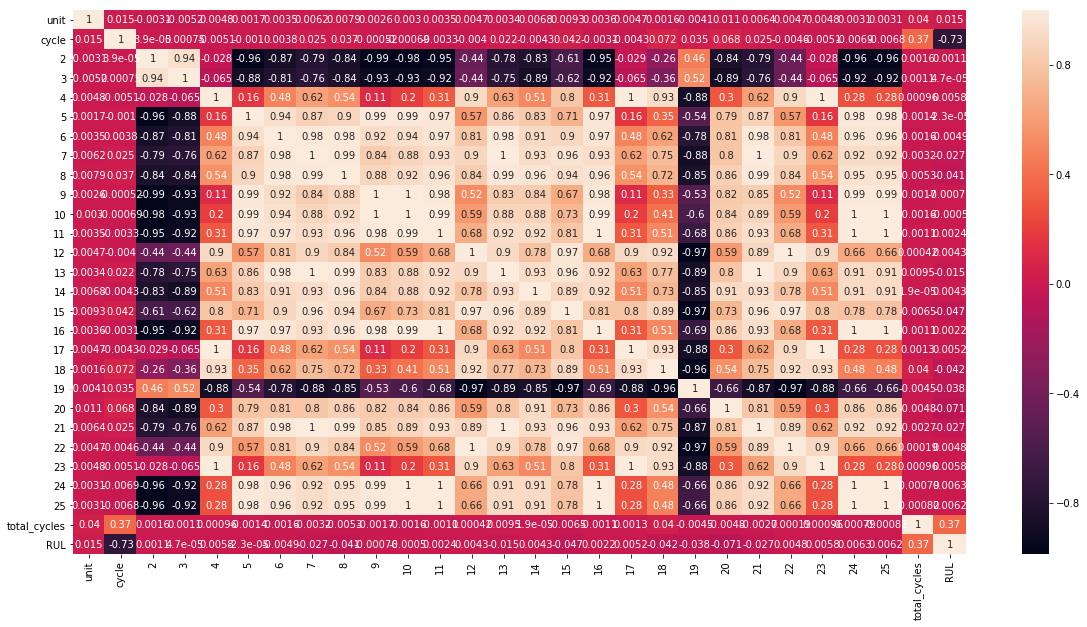

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(train_fd1.corr() , annot = True)


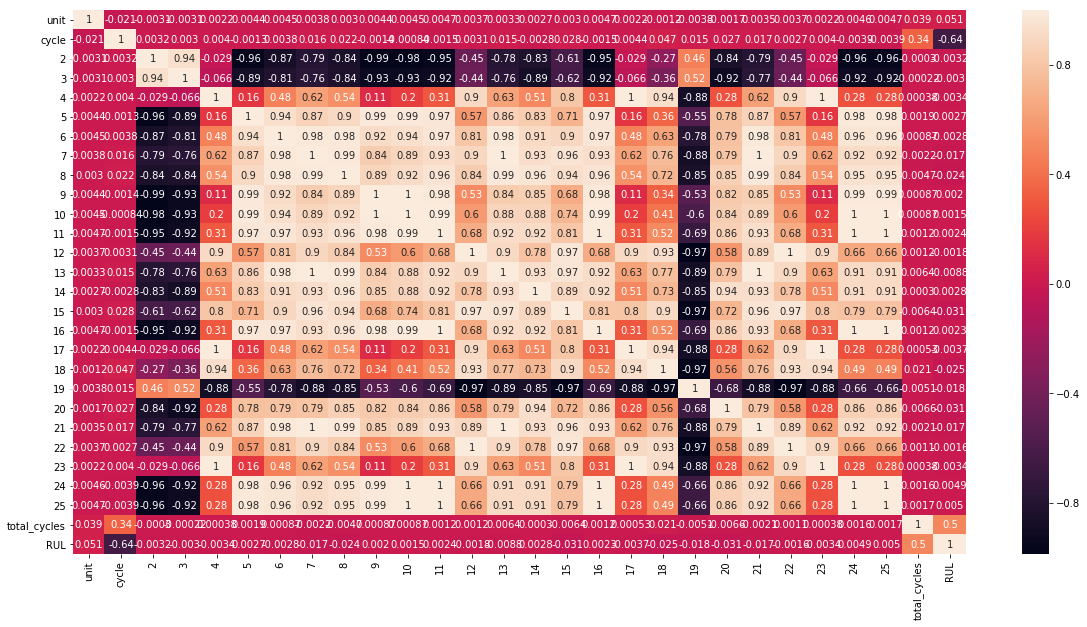

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(test_fd1.corr() , annot = True)

In [12]:
features = list(range(2, 26))

train_fd1[features] = train_fd1[features].apply(normalize, axis = 0)
test_fd1[features] = test_fd1[features].apply(normalize, axis = 0)

test_rows = test_fd1.groupby(['unit']).agg({'cycle' : max})
test_rows = test_rows.reset_index()
test_rows = test_rows.merge(test_fd1, how = 'left', left_on = ['unit', 'cycle'],
                                                    right_on = ['unit', 'cycle'])

In [13]:
y = train_fd1['RUL'].values

X_pred = test_rows[features].dropna(how = 'all', axis = 1)

X = train_fd1[features].dropna(how = 'all', axis = 1)

X = X.as_matrix()
X_pred = X_pred.as_matrix()

y_real = test_rows['RUL'].values

In [14]:
print(y.shape)
print(X.shape)
print(X_pred.shape)
print(y_real.shape)

(53759,)
(53759, 24)
(259, 24)
(259,)


In [15]:
feature_columns = [tf.feature_column.numeric_column("x", shape = [24])]

regressor = tf.estimator.DNNRegressor(feature_columns = feature_columns,
                                      hidden_units    = [15, 30, 15])

train_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": X},
                                                    y = np.array(y, dtype = np.int),
                                                    num_epochs = None,
                                                    shuffle = True)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": np.array(X_pred)},
                                                      num_epochs = 1,
                                                      shuffle = False)

regressor.train(input_fn = train_input_fn, steps = 100)
y_pred = regressor.predict(predict_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\dell\\AppData\\Local\\Temp\\tmpistr0iff', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000029508D8CBE0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for upd

In [16]:
print(y_pred)

<generator object Estimator.predict at 0x0000029506943518>


In [17]:
y_pred = [val for val in y_pred]
y_pred = np.array(list(map(lambda x: x['predictions'][0], y_pred)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\dell\AppData\Local\Temp\tmpistr0iff\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [18]:
print(y_pred)

[ 79.49786   94.58662   97.85407  107.14606   86.483894 102.39833
 101.133965  94.11999   92.88241  107.935005  91.263695  94.82397
 101.04499   64.750824  81.569565 100.93356   96.16524   95.86231
  95.56982   96.22321  101.17281   86.75277   99.39515   84.062836
  96.083405 100.92181   95.71248  103.34518   82.650024  97.56486
 103.55104   93.37034   99.20698  104.70589  103.66623   99.16396
 100.93684   64.52125   95.601425  95.983536  96.42147   97.66265
  89.07166   94.55551   81.17275  109.25227   95.9203    96.77084
  83.102455  87.83098   95.205444  82.53546   92.70854  104.025665
  83.952545 104.8331   102.8924    63.861805 102.6637    99.82476
  81.21728   94.13333   93.98541   88.12513   90.90576   99.589874
  99.45785   93.46547  101.01044   92.63729  102.52132   98.86927
  82.03955   98.55705  109.16555   93.784904  81.681206  95.757126
 102.45545   89.92863  110.31422   97.71176  105.18381   81.34346
  97.08242   94.83869   80.65002  100.76354   82.35836   86.36994
  95.1

In [19]:
print(len(X))

53759


In [20]:
print(len(y))

53759


In [21]:
print(len(y_pred))

259


In [22]:
print(len(y_real))

259


In [23]:
len(y_real) == len(y_pred)

True

In [24]:
print(y_real)

[ 18  79 106 110  15 155   6  90  11  79   6  73  30  11  37  67  68  99
  22  54  97  10 142  77  88 163 126 138  83  78  75  11  53 173  63 100
 151  55  48  37  44  27  18   6  15 112 131  13 122  13  98  53  52 106
 103 152 123  26 178  73 169  39  39  14  11 121  86  56 115  17 148 104
  78  86  98  36  94  52  91  15 141  74 146  17  47 194  21  79  97   8
   9  73 183  97  73  49  31  97   9  14 106   8   8 106 116 120  61 168
  35  80   9  50 151  78  91   7 181 150 106  15  67 145 180   7 179 124
  82 108  79 121 120  39  38   9 167  87  88   7  51  55 155  47  81  43
  98  10  92  11 165  34 115  59  99 103 108  83 171  15   9  42  13  41
  88  14 155 188  96  82 135 182  36 107  14  95 142  23   6 144  35  97
  68  14  67 191  19  10 158 183  43  12 148  13  37 122  80  93 132  32
 103 174 111  68 192 121 134  48  85   8  23   8   6  57  83 172 101  81
  86 165  73 121 139  75 151 145  11 108  14 126  61  85   8 101 153  89
 190  12  62 134 101 121 167  17 161 181  16 152 14

# Various Machine Learning Models for Prediction

# Neural Network Regressor

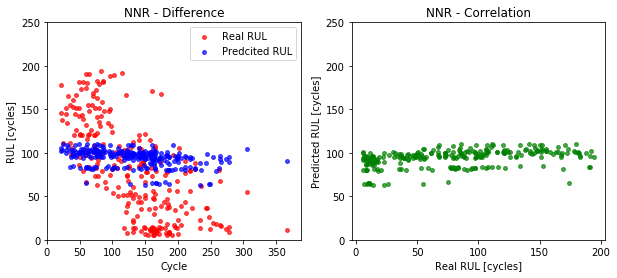

In [25]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_pred, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('NNR - Difference')

axes[1].scatter(y_real, y_pred, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('NNR - Correlation')

axes[0].legend()

plt.show()

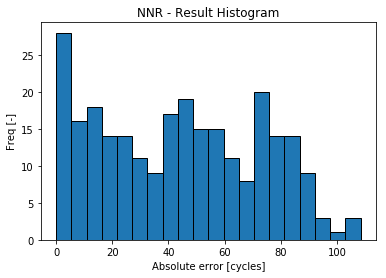

In [26]:
plt.hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('NNR - Result Histogram')
plt.show()

In [27]:
print('Average score per UUT:', compute_score(y_real, y_pred) / 100)
print('Mean squared Error:', MSE(y_real, y_pred))
print('Median difference:', np.median(np.abs(y_real - y_pred)))

Average score per UUT: 2009.9343779247292
Mean squared Error: 3.2456347727182604
Median difference: 44.61724853515625


# Support Vector Machine Regressor

In [28]:
model = svm.SVR()
model.fit(X, y)
y_pred_svm = model.predict(X_pred)

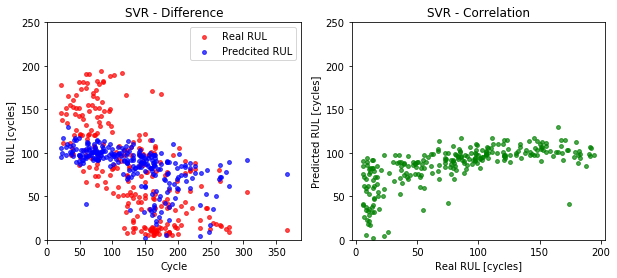

In [29]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_pred_svm, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('SVR - Difference')

axes[1].scatter(y_real, y_pred_svm, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('SVR - Correlation')

axes[0].legend()

plt.show()

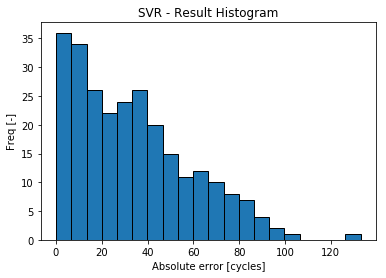

In [30]:
plt.hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('SVR - Result Histogram')
plt.show()

In [31]:
print('Average score per UUT:', compute_score(y_real, y_pred_svm) / 100)
print('Mean squared Error:', MSE(y_real, y_pred_svm))
print('Median difference:', np.median(np.abs(y_real - y_pred_svm)))

Average score per UUT: 845.5696722033966
Mean squared Error: 2.621886446357004
Median difference: 29.527322643523448


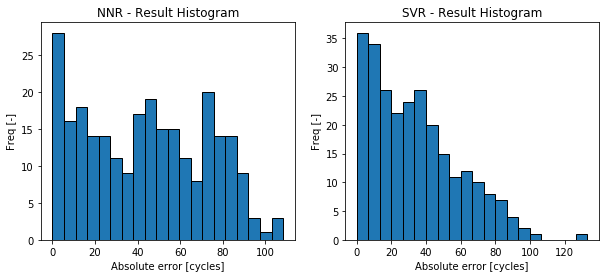

In [32]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
axes[0].hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
axes[0].set_xlabel('Absolute error [cycles]')
axes[0].set_ylabel('Freq [-]')
axes[0].set_title('NNR - Result Histogram')

axes[1].hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
axes[1].set_xlabel('Absolute error [cycles]')
axes[1].set_ylabel('Freq [-]')
axes[1].set_title('SVR - Result Histogram')
plt.show()

# Decision Tree Regressor

In [33]:
regr_1 = DecisionTreeRegressor(max_depth= 4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth= 4),
                          n_estimators=300, random_state = None)

regr_1.fit(X, y)
regr_2.fit(X, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=None)

In [34]:
y_1 = regr_1.predict(X_pred)
y_2 = regr_2.predict(X_pred)

In [35]:
print(len(X))
print(len(y))
print(len(y_1))
print(len(y_2))
len(X) == len(y)

53759
53759
259
259


True

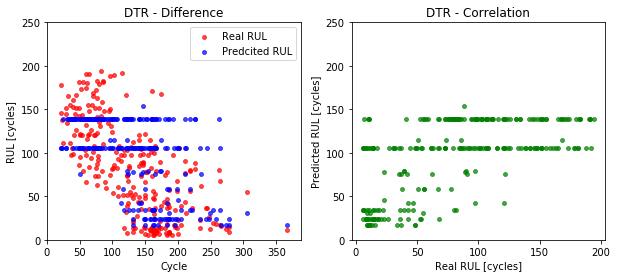

In [36]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_1, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('DTR - Difference')

axes[1].scatter(y_real, y_1, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('DTR - Correlation')

axes[0].legend()

plt.show()

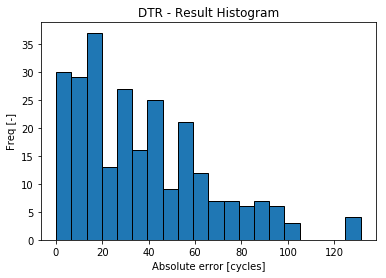

In [37]:
plt.hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('DTR - Result Histogram')
plt.show()

In [38]:
print('Average score per UUT:', compute_score(y_real, y_1) / 100)
print('Mean squared Error:', MSE(y_real, y_1))
print('Median difference:', np.median(np.abs(y_real - y_1)))

Average score per UUT: 18049.506594349466
Mean squared Error: 2.9043652868518657
Median difference: 32.33109888406696


# Decision Tree Regressor using Adaboost

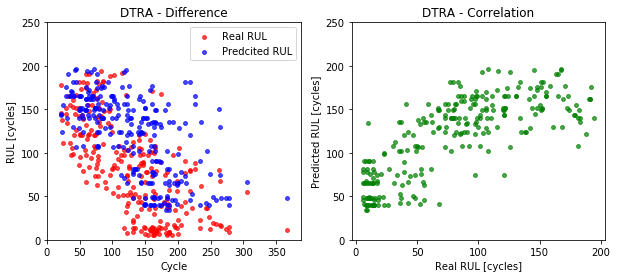

In [39]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_2, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('DTRA - Difference')

axes[1].scatter(y_real, y_2, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('DTRA - Correlation')

axes[0].legend()

plt.show()

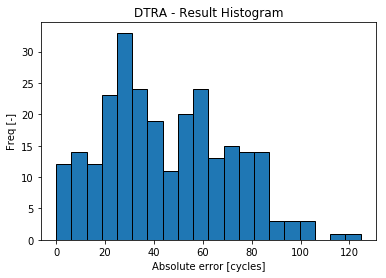

In [40]:
plt.hist(np.abs(y_real - y_2), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('DTRA - Result Histogram')
plt.show()

In [41]:
print('Average score per UUT:', compute_score(y_real, y_2) / 100)
print('Mean squared Error:', MSE(y_real, y_2))
print('Median difference:', np.median(np.abs(y_real - y_2)))

Average score per UUT: 6582.2560414621785
Mean squared Error: 3.21737580873923
Median difference: 40.8318418136879


# KNN Regressor

In [42]:
neigh = KNeighborsRegressor(n_neighbors=7)
neigh.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')

In [43]:
KNeighborsRegressor()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [44]:
y_3 = neigh.predict(X_pred)

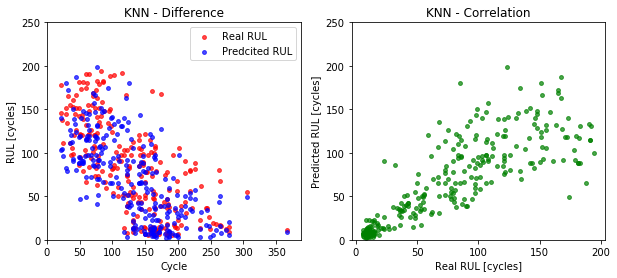

In [45]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_3, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('KNN - Difference')

axes[1].scatter(y_real, y_3, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('KNN - Correlation')

axes[0].legend()

plt.show()

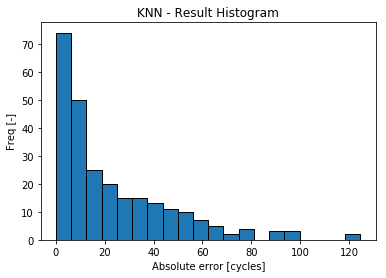

In [46]:
plt.hist(np.abs(y_real - y_3), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('KNN - Result Histogram')
plt.show()

In [47]:
print('Average score per UUT:', compute_score(y_real, y_3) / 100)
print('Mean squared Error:', MSE(y_real, y_3))
print('Median difference:', np.median(np.abs(y_real - y_3)))

Average score per UUT: 564.6366095714362
Mean squared Error: 2.0698925264172336
Median difference: 14.285714285714285


# Random Forest Regressor

In [48]:
regr1 = RandomForestRegressor(max_depth=2, random_state=0,
                             n_estimators=100)
regr1.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [49]:
y_4 = regr1.predict(X_pred)

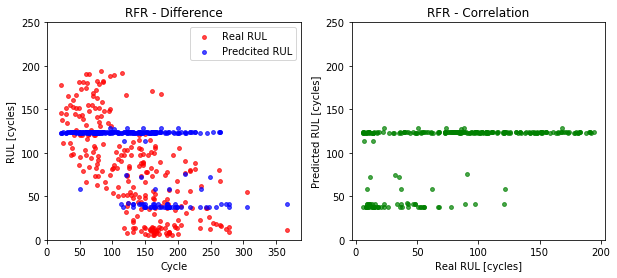

In [50]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_4, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('RFR - Difference')

axes[1].scatter(y_real, y_4, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('RFR - Correlation')

axes[0].legend()

plt.show()

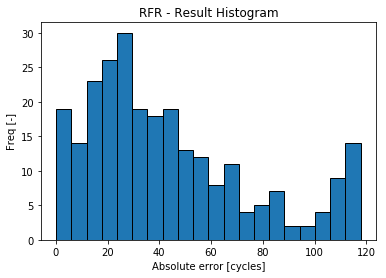

In [51]:
plt.hist(np.abs(y_real - y_4), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('RFR - Result Histogram')
plt.show()

In [52]:
print('Average score per UUT:', compute_score(y_real, y_4) / 100)
print('Mean squared Error:', MSE(y_real, y_4))
print('Median difference:', np.median(np.abs(y_real - y_4)))

Average score per UUT: 21718.549659215034
Mean squared Error: 3.3406186718788264
Median difference: 33.778169567835164


# Conclusion

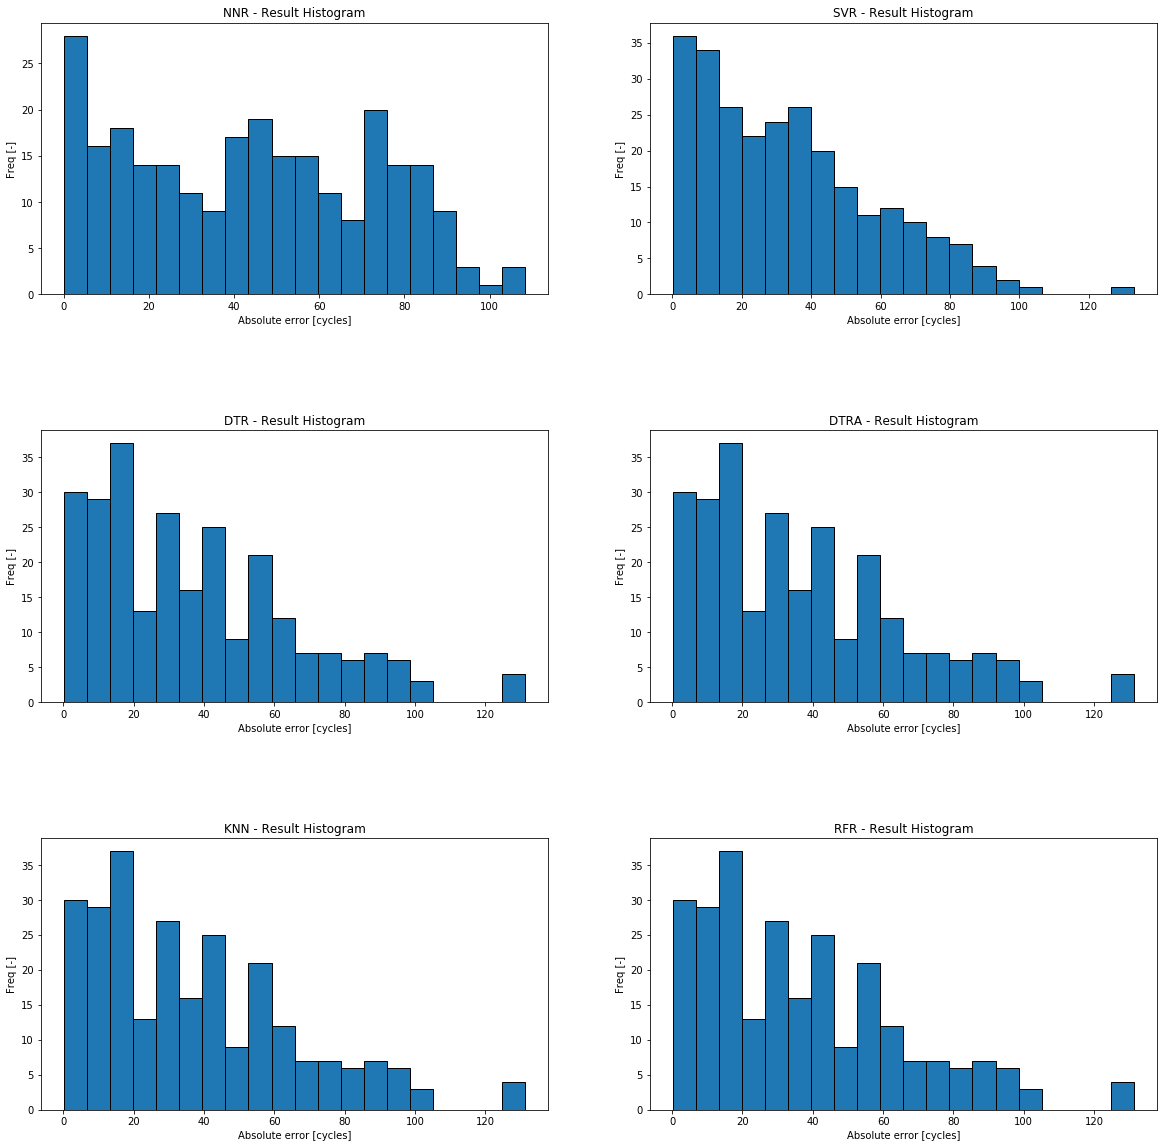

In [53]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
axes[0,0].hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
axes[0,0].set_xlabel('Absolute error [cycles]')
axes[0,0].set_ylabel('Freq [-]')
axes[0,0].set_title('NNR - Result Histogram')

axes[0,1].hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
axes[0,1].set_xlabel('Absolute error [cycles]')
axes[0,1].set_ylabel('Freq [-]')
axes[0,1].set_title('SVR - Result Histogram')

axes[1,0].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[1,0].set_xlabel('Absolute error [cycles]')
axes[1,0].set_ylabel('Freq [-]')
axes[1,0].set_title('DTR - Result Histogram')

axes[1,1].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[1,1].set_xlabel('Absolute error [cycles]')
axes[1,1].set_ylabel('Freq [-]')
axes[1,1].set_title('DTRA - Result Histogram')

axes[2,0].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[2,0].set_xlabel('Absolute error [cycles]')
axes[2,0].set_ylabel('Freq [-]')
axes[2,0].set_title('KNN - Result Histogram')

axes[2,1].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[2,1].set_xlabel('Absolute error [cycles]')
axes[2,1].set_ylabel('Freq [-]')
axes[2,1].set_title('RFR - Result Histogram')

plt.show()